Expected Returns:
TSLA   -0.000036
BND     0.020434
SPY     0.142850
dtype: float64


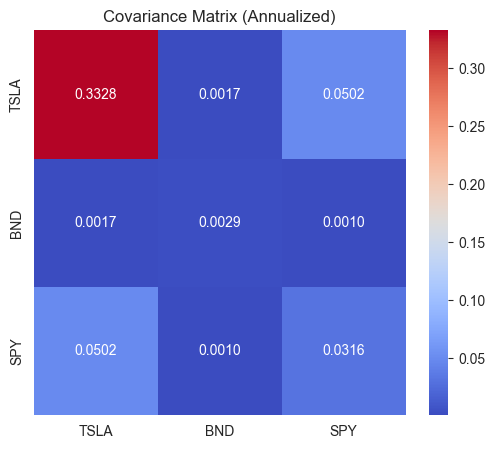


Max Sharpe Portfolio:
OrderedDict([('TSLA', 0.0), ('BND', 0.56249), ('SPY', 0.43751)])
Expected Annual Return: 7.40%, Volatility: 8.63%, Sharpe Ratio: 0.86

Min Volatility Portfolio:
OrderedDict([('TSLA', 0.0), ('BND', 0.94272), ('SPY', 0.05728)])
Expected Annual Return: 2.74%, Volatility: 5.26%, Sharpe Ratio: 0.52


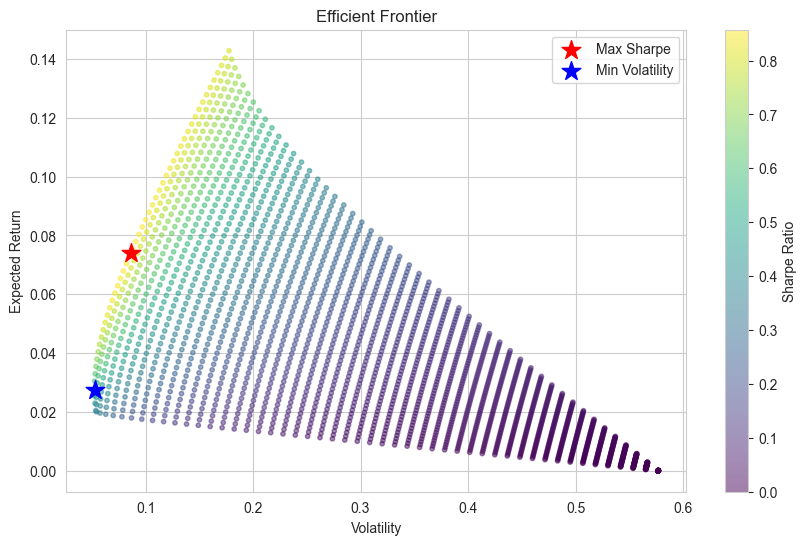


Discrete Allocation (for $100,000 portfolio):
{'BND': 757, 'SPY': 63}
Funds Remaining: $163.81


In [59]:
# -------------------------
# Task 4 - Portfolio Optimization
# -------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

sns.set_style("whitegrid")

# -------------------------
# 1. Load Historical Data and TSLA Forecast
# -------------------------
prices = pd.read_csv("../data/processed/historical_prices.csv", index_col="Date", parse_dates=True)
returns = pd.read_csv("../data/processed/daily_returns.csv", index_col="Date", parse_dates=True)

# TSLA forecast expected return from Task 3
tsla_forecast = pd.read_csv("../data/processed/tsla_forecast.csv", index_col="Date", parse_dates=True)
tsla_expected_return = tsla_forecast["Forecast"].pct_change().mean() * 252  # annualized

# Historical annualized returns for BND and SPY
bnd_expected_return = returns['BND'].mean() * 252
spy_expected_return = returns['SPY'].mean() * 252

expected_returns = pd.Series({
    "TSLA": tsla_expected_return,
    "BND": bnd_expected_return,
    "SPY": spy_expected_return
})

print("Expected Returns:")
print(expected_returns)

# -------------------------
# 2. Covariance Matrix
# -------------------------
# Compute covariance matrix using daily returns
cov_matrix = returns[['TSLA', 'BND', 'SPY']].cov() * 252  # annualized

# Optional: visualize covariance matrix
plt.figure(figsize=(6,5))
sns.heatmap(cov_matrix, annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Covariance Matrix (Annualized)")
plt.show()

# -------------------------
# 3. Efficient Frontier
# -------------------------
ef = EfficientFrontier(expected_returns, cov_matrix)
# Max Sharpe Portfolio
ef_max_sharpe = EfficientFrontier(expected_returns, cov_matrix)
ef_max_sharpe.max_sharpe(risk_free_rate=0.0)
weights_max_sharpe = ef_max_sharpe.clean_weights()
ret_max_sharpe, vol_max_sharpe, sharpe_max_sharpe = ef_max_sharpe.portfolio_performance()

# Min Volatility Portfolio
ef_min_vol = EfficientFrontier(expected_returns, cov_matrix)
ef_min_vol.min_volatility()
weights_min_vol = ef_min_vol.clean_weights()
ret_min_vol, vol_min_vol, sharpe_min_vol = ef_min_vol.portfolio_performance()

print("\nMax Sharpe Portfolio:")
print(weights_max_sharpe)
print(f"Expected Annual Return: {ret_max_sharpe:.2%}, Volatility: {vol_max_sharpe:.2%}, Sharpe Ratio: {sharpe_max_sharpe:.2f}")

print("\nMin Volatility Portfolio:")
print(weights_min_vol)
print(f"Expected Annual Return: {ret_min_vol:.2%}, Volatility: {vol_min_vol:.2%}, Sharpe Ratio: {sharpe_min_vol:.2f}")

# -------------------------
# 4. Plot Efficient Frontier
# -------------------------
# Generate frontier points

rets = []
vols = []

for w1 in np.linspace(0,1,50):
    for w2 in np.linspace(0, 1-w1, 50):
        w3 = 1 - w1 - w2
        w = np.array([w1, w2, w3])
        port_ret = np.dot(w, expected_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        rets.append(port_ret)
        vols.append(port_vol)

plt.figure(figsize=(10,6))
plt.scatter(vols, rets, c=np.array(rets)/np.array(vols), cmap="viridis", marker='o', s=10, alpha=0.5)
plt.colorbar(label="Sharpe Ratio")

# Plot Max Sharpe and Min Volatility points
plt.scatter(vol_max_sharpe, ret_max_sharpe, marker="*", color="r", s=200, label="Max Sharpe")
plt.scatter(vol_min_vol, ret_min_vol, marker="*", color="b", s=200, label="Min Volatility")

plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.legend()
plt.show()


# -------------------------
# 5. Recommended Portfolio (Max Sharpe)
# -------------------------
latest_prices = get_latest_prices(prices[['TSLA','BND','SPY']])
da = DiscreteAllocation(weights_max_sharpe, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.lp_portfolio()

print("\nDiscrete Allocation (for $100,000 portfolio):")
print(allocation)
print(f"Funds Remaining: ${leftover:.2f}")
